In [1]:
'''
python T1_BT19_Icub_joint_unspv.py -k 0 -c 0
'''
# Import

import os,sys
CURRENT_TEST_DIR = os.getcwd()
sys.path.append(CURRENT_TEST_DIR + "/../new_iteration/")
import pickle
import argparse
from sklearn.metrics import confusion_matrix
from datetime import datetime

from vrae.vrae import VRAEC
from vrae.utils import *
import numpy as np
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import torch.nn.functional as F
import torch.optim as optim
from torch.utils import data as data2
from torch.utils.data.dataset import random_split
from torch.utils.data import DataLoader, TensorDataset
from datetime import datetime
from tas_utils_bs import get_trainValLoader, get_testLoader
import plotly


In [2]:
# Parse argument
parser = argparse.ArgumentParser()
parser.add_argument("-k", "--kfold", type=int, default=0, help="kfold_number for loading data")
parser.add_argument("-r", "--reduction", type=int, default=1, help="data reduction ratio for partial training")
parser.add_argument("-c", "--cuda", default=0, help="index of cuda gpu to use")
args = parser.parse_args()

In [3]:
# # dummy class to replace argparser
# class Args:
#   kfold = 0
#   reduction = 1
#   cuda = '1'

# args=Args()

In [4]:
print("load {} kfold number, reduce data to {} folds, put to cuda:{}".format(args.kfold, args.reduction, args.cuda))

# Set hyper params
kfold_number = args.kfold
data_reduction_ratio = args.reduction
shuffle = False
num_class = 20
sequence_length_B = 400
sequence_length_I = 75
number_of_features_B = 19
number_of_features_I = 60

hidden_size = 90
hidden_layer_depth = 1
latent_length = 40
batch_size = 32
learning_rate = 0.0005
n_epochs = 2000

learning_rate_2 = 0.01
n_epochs_2 = 2000

dropout_rate = 0.2
cuda = True # options: True, False
print_every=30
clip = True # options: True, False
max_grad_norm=5
header_B = None
header_I = "CNN"

w_r = 0.01
w_k = 1
w_c = 1

w_rB = 1
w_rI = 1
w_c = 1

np.random.seed(1)
torch.manual_seed(1)

load 0 kfold number, reduce data to 1 folds, put to cuda:1


### Load data and preprocess

In [5]:
# Load data
data_dir = '../../new_data_folder/'

logDir = 'models_and_stat/'
# new model
model_name_B = 'BT19_joint_unspv_wrB_{}_wrI_{}_wC_{}_{}'.format(w_rB, w_rI, w_c, str(kfold_number))
model_name_I = 'IcubCNN_joint_unspv_wrB_{}_wrI_{}_wC_{}_{}'.format(w_rB, w_rI, w_c, str(kfold_number))

device = torch.device("cuda:{}".format(args.cuda))
print("Loading data...")

train_loader, val_loader, train_dataset, val_dataset = get_trainValLoader(data_dir, k=kfold_number, spike_ready=False, batch_size=batch_size, shuffle=shuffle)
test_loader, test_dataset = get_testLoader(data_dir, spike_ready=False, batch_size=batch_size, shuffle=shuffle)

Loading data...


In [6]:
model_B = VRAEC(num_class=num_class,
            sequence_length=sequence_length_B,
            number_of_features = number_of_features_B,
            hidden_size = hidden_size, 
            hidden_layer_depth = hidden_layer_depth,
            latent_length = latent_length,
            batch_size = batch_size,
            learning_rate = learning_rate,
            n_epochs = n_epochs,
            dropout_rate = dropout_rate, 
            cuda = cuda,
            print_every=print_every, 
            clip=clip, 
            max_grad_norm=max_grad_norm,
            dload = logDir,
            model_name=model_name_B,
            header=header_B,
            device = device)
model_B.to(device)

model_I = VRAEC(num_class=num_class,
            sequence_length=sequence_length_I,
            number_of_features = number_of_features_I,
            hidden_size = hidden_size, 
            hidden_layer_depth = hidden_layer_depth,
            latent_length = latent_length,
            batch_size = batch_size,
            learning_rate = learning_rate,
            n_epochs = n_epochs,
            dropout_rate = dropout_rate, 
            cuda = cuda,
            print_every=print_every, 
            clip=clip, 
            max_grad_norm=max_grad_norm,
            dload = logDir,
            model_name=model_name_I,
            header=header_I,
            w_r = w_r, 
            w_k = w_k, 
            w_c = w_c,
            device = device)
model_I.to(device)

loss weights for vraec w_r: 0.01, w_k: 1, w_c: 1


/home/students/student6_16/anaconda3/lib/python3.7/site-packages/torch/nn/modules/rnn.py:51: UserWarning:

dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1



loss weights for vraec w_r: 0.01, w_k: 1, w_c: 1


VRAE(n_epochs=20,batch_size=32,cuda=True)

In [7]:
criterion = nn.CrossEntropyLoss()
optimB = optim.Adam(model_B.parameters(), lr=learning_rate)
optimI = optim.Adam(model_I.parameters(), lr=learning_rate)
cl_loss_fn = nn.NLLLoss()
recon_loss_fn = nn.MSELoss()

In [8]:
# 1st stage training: with recon_loss and mse_loss
training_start=datetime.now()

epoch_train_loss_B = []
epoch_train_acc_B = []
epoch_val_loss_B = []
epoch_val_acc_B = []
max_val_acc_B = 0

epoch_train_loss_I = []
epoch_train_acc_I = []
epoch_val_loss_I = []
epoch_val_acc_I = []

epoch_train_tot_loss = []
epoch_val_tot_loss = []
max_val_acc_I = 0

for epoch in range(n_epochs):

    # TRAIN
    model_B.train()
    model_I.train()

    correct_B = 0
    train_loss_B = 0
    correct_I = 0
    train_loss_I = 0
    train_loss_tot = 0
    train_num = 0
            
    for i, (XI, XB,  y) in enumerate(train_loader):
        XI, XB, y = XI.to(device), XB.to(device), y.long().to(device)
        
        if XI.size()[0] != batch_size:
#             print("batch {} size {} < {}, skip".format(i, x.size()[0], batch_size))
            break

        train_num += XI.size(0)
        
        # train model_B
        optimB.zero_grad()  
        x_decoded_B, latent_B, output = model_B(XB)
        
        # construct loss function
        loss_B = recon_loss_fn(x_decoded_B, XB)
        
        # compute classification acc
        pred = output.data.max(1, keepdim=True)[1]  # get the index of the max log-probability
        correct_B += pred.eq(y.data.view_as(pred)).long().cpu().sum().item()
        # accumulator
        train_loss_B += loss_B.item()
        
        
        # train modelI
        optimI.zero_grad()  
        x_decoded_I, latent_I, output = model_I(XI)
        
        # construct loss function
        loss_I = recon_loss_fn(x_decoded_I, XI)

        # compute classification acc
        pred = output.data.max(1, keepdim=True)[1]  # get the index of the max log-probability
        correct_I += pred.eq(y.data.view_as(pred)).long().cpu().sum().item()
        # accumulator
        train_loss_I += loss_I.item()
        
        loss_C = F.mse_loss(latent_B, latent_I)
        loss = w_rB*loss_B + w_rI*loss_I + w_c*loss_C
        
        if epoch < 20:
            loss_B.backward()
            loss_I.backward()
        else:
            loss.backward()
        
        train_loss_tot += loss.item()
        
        optimB.step() 
        optimI.step() 
    
    if epoch < 20 or epoch%200 == 0:
        print("last batch training: LB: {:.2f}, LI: {:.2f}, LC: {:.2f} "\
      .format(loss_B, loss_I, loss_C))
    
    # fill stats
    train_accuracy_B = correct_B / train_num # len(train_loader.dataset)
    train_loss_B /= train_num #len(train_loader.dataset)
    epoch_train_loss_B.append(train_loss_B)
    epoch_train_acc_B.append(train_accuracy_B) 
    
    train_accuracy_I = correct_I / train_num # len(train_loader.dataset)
    train_loss_I /= train_num #len(train_loader.dataset)
    epoch_train_loss_I.append(train_loss_I)
    epoch_train_acc_I.append(train_accuracy_I) 
    

    # VALIDATION
    model_B.eval()
    model_I.eval()

    correct_B = 0
    val_loss_B = 0
    correct_I = 0
    val_loss_I = 0
    val_loss_tot = 0
    val_num = 0

    for i, (XI, XB,  y) in enumerate(val_loader):
        XI, XB, y = XI.to(device), XB.to(device), y.long().to(device)
        
        if XI.size()[0] != batch_size:
#             print("batch {} size {} < {}, skip".format(i, x.size()[0], batch_size))
            break

        val_num += XI.size(0)
        
        # eval model_B
        x_decoded_B, latent_B, output = model_B(XB)
        # construct loss function
        loss_B = recon_loss_fn(x_decoded_B, XB)

        # compute classification acc
        pred = output.data.max(1, keepdim=True)[1]  # get the index of the max log-probability
        correct_B += pred.eq(y.data.view_as(pred)).long().cpu().sum().item()
        # accumulator
        val_loss_B += loss_B.item()
        
        
        # eval modelI 
        x_decoded_I, latent_I, output = model_I(XI)
        # construct loss function
        loss_I = recon_loss_fn(x_decoded_I, XI)
     
        # compute classification acc
        pred = output.data.max(1, keepdim=True)[1]  # get the index of the max log-probability
        correct_I += pred.eq(y.data.view_as(pred)).long().cpu().sum().item()
        # accumulator
        val_loss_I += loss_I.item()
        
        loss_C = F.mse_loss(latent_B, latent_I)
        loss = w_rB*loss_B + w_rI*loss_I + w_c*loss_C
        val_loss_tot += loss.item()

    # fill stats
    val_accuracy_B = correct_B / val_num # len(train_loader.dataset)
    val_loss_B /= val_num #len(train_loader.dataset)
    epoch_val_loss_B.append(val_loss_B)
    epoch_val_acc_B.append(val_accuracy_B) 
    
    val_accuracy_I = correct_I / val_num # len(train_loader.dataset)
    val_loss_I /= val_num #len(train_loader.dataset)
    epoch_val_loss_I.append(val_loss_I)
    epoch_val_acc_I.append(val_accuracy_I) 
    
    if epoch < 20 or epoch%200 == 0:
#         print("train_num {}, val_num {}".format(train_num, val_num))
        print("Epoch {}: Loss: lc {:.3f},  train_B {:.3f}, val_B {:.3f}, train_I{:.3f}, val_I{:.3f}, \n\t\t Acc: train_B {:.3f}, val_B {:.3f}, train_I {:.3f}, val_I {:.3f}"\
              .format(epoch, loss_C, train_loss_B, val_loss_B, train_loss_I, val_loss_I, train_accuracy_B, val_accuracy_B, train_accuracy_I, val_accuracy_I))
        print("-"*20)
    # choose model
    # TODO: not save at the same time, may have bad common representation
    if max_val_acc_B <= val_accuracy_B:
        model_dir = logDir + model_name_B + '.pt'
        print("Saving model at {} epoch to {}".format(epoch, model_dir))
        max_val_acc_B = val_accuracy_B
        torch.save(model_B.state_dict(), model_dir)

    if max_val_acc_I <= val_accuracy_I:
        model_dir = logDir + model_name_I + '.pt'
        print("Saving model at {} epoch to {}".format(epoch, model_dir))
        max_val_acc_I = val_accuracy_I
        torch.save(model_I.state_dict(), model_dir)
    

training_end =  datetime.now()
training_time = training_end -training_start 
print("RAE training takes time {}".format(training_time)) 

last batch training: LB: 384.25, LI: 241.75, LC: 1.10 
Epoch 0: Loss: lc 1.086,  train_B 12.159, val_B 11.989, train_I7.250, val_I7.121, 
		 Acc: train_B 0.009, val_B 0.047, train_I 0.040, val_I 0.047
--------------------
Saving model at 0 epoch to models_and_stat/BT19_joint_unspv_wrB_1_wrI_1_wC_1_0.pt
Saving model at 0 epoch to models_and_stat/IcubCNN_joint_unspv_wrB_1_wrI_1_wC_1_0.pt
last batch training: LB: 348.81, LI: 238.83, LC: 5.37 
Epoch 1: Loss: lc 5.570,  train_B 11.781, val_B 10.804, train_I7.214, val_I7.031, 
		 Acc: train_B 0.052, val_B 0.052, train_I 0.042, val_I 0.057
--------------------
Saving model at 1 epoch to models_and_stat/BT19_joint_unspv_wrB_1_wrI_1_wC_1_0.pt
Saving model at 1 epoch to models_and_stat/IcubCNN_joint_unspv_wrB_1_wrI_1_wC_1_0.pt
last batch training: LB: 310.11, LI: 235.73, LC: 12.03 
Epoch 2: Loss: lc 12.066,  train_B 10.312, val_B 9.664, train_I7.113, val_I6.946, 
		 Acc: train_B 0.052, val_B 0.052, train_I 0.054, val_I 0.052
--------------------

In [9]:
# 2nd stage training: train classifier using classification loss

epoch_cl_train_loss_B = []
epoch_cl_train_acc_B = []
epoch_cl_val_loss_B = []
epoch_cl_val_acc_B = []
max_cl_val_acc_B = 0

epoch_cl_train_loss_I = []
epoch_cl_train_acc_I = []
epoch_cl_val_loss_I = []
epoch_cl_val_acc_I = []
max_cl_val_acc_I = 0

epoch_cl_train_tot_loss = []
epoch_cl_val_tot_loss = []

optimB = optim.Adam(model_B.parameters(), lr=learning_rate_2)
optimI = optim.Adam(model_I.parameters(), lr=learning_rate_2)

for epoch in range(n_epochs_2):

    # TRAIN
    model_B.train()
    model_I.train()

    correct_B = 0
    train2_loss_B = 0
    correct_I = 0
    train2_loss_I = 0
    train2_loss_tot = 0
    train_num = 0
    
    # freeze params except for the classifier
    trained_names = ['classifier.0.bias', 'classifier.0.weight']
    for name, param in model_B.named_parameters():
        if name in trained_names:
            param.requires_grad = True
        else:
            param.requires_grad = False
    for name, param in model_I.named_parameters():
        if name in trained_names:
            param.requires_grad = True
        else:
            param.requires_grad = False
            
    for i, (XI, XB,  y) in enumerate(train_loader):
        XI, XB, y = XI.to(device), XB.to(device), y.long().to(device)
        
        if XI.size()[0] != batch_size:
#             print("batch {} size {} < {}, skip".format(i, x.size()[0], batch_size))
            break

        train_num += XI.size(0)       

        
        # train model_B
        optimB.zero_grad()  
        x_decoded_B, latent_B, output = model_B(XB)
        
        # construct loss function
        loss_B = cl_loss_fn(output, y)
        
        # compute classification acc
        pred = output.data.max(1, keepdim=True)[1]  # get the index of the max log-probability
        correct_B += pred.eq(y.data.view_as(pred)).long().cpu().sum().item()
        # accumulator
        train2_loss_B += loss_B.item()
        
        
        # train modelI
        optimI.zero_grad()  
        x_decoded_I, latent_I, output = model_I(XI)
        
        # construct loss function
        loss_I = cl_loss_fn(output, y)
        # compute classification acc
        pred = output.data.max(1, keepdim=True)[1]  # get the index of the max log-probability
        correct_I += pred.eq(y.data.view_as(pred)).long().cpu().sum().item()
        # accumulator
        train2_loss_I += loss_I.item()
        
        loss_C = F.mse_loss(latent_B, latent_I)
        loss = w_rB*loss_B + w_rI*loss_I + w_c*loss_C
        
        if epoch < 20:
            loss_B.backward()
            loss_I.backward()
        else:
            loss.backward()
        
        train2_loss_tot += loss.item()
        
        optimB.step() 
        optimI.step() 
    
    train2_accuracy_B = correct_B / train_num # len(train_loader.dataset)
    train2_accuracy_I = correct_I / train_num # len(train_loader.dataset)
        
    if epoch < 20 or epoch%200 == 0:
        print("classifier last batch training: epoch: {}. LB: {:.2f}, LI: {:.2f}, acc_B: {:.2f}, acc_I: {:.2f}"\
              .format(epoch, loss_B, loss_I, train2_accuracy_B, train2_accuracy_I))
 
    # fill stats
    train2_accuracy_B = correct_B / train_num # len(train_loader.dataset)
    train2_loss_B /= train_num #len(train_loader.dataset)
    epoch_cl_train_loss_B.append(train2_loss_B)
    epoch_cl_train_acc_B.append(train2_accuracy_B) 
    
    train2_accuracy_I = correct_I / train_num # len(train_loader.dataset)
    train2_loss_I /= train_num #len(train_loader.dataset)
    epoch_cl_train_loss_I.append(train2_loss_I)
    epoch_cl_train_acc_I.append(train2_accuracy_I) 
    
    
    
    # VALIDATION
    model_B.eval()
    model_I.eval()

    correct_B = 0
    val2_loss_B = 0
    correct_I = 0
    val2_loss_I = 0
    val2_loss_tot = 0
    val_num = 0

    for i, (XI, XB,  y) in enumerate(val_loader):
        XI, XB, y = XI.to(device), XB.to(device), y.long().to(device)
        
        if XI.size()[0] != batch_size:
#             print("batch {} size {} < {}, skip".format(i, x.size()[0], batch_size))
            break

        val_num += XI.size(0)
        
        # eval model_B
        x_decoded_B, latent_B, output = model_B(XB)
        # construct loss function
        loss_B = cl_loss_fn(output, y)

        # compute classification acc
        pred = output.data.max(1, keepdim=True)[1]  # get the index of the max log-probability
        correct_B += pred.eq(y.data.view_as(pred)).long().cpu().sum().item()
        # accumulator
        val2_loss_B += loss_B.item()
        
        
        # eval modelI 
        x_decoded_I, latent_I, output = model_I(XI)
        # construct loss function
        loss_I = cl_loss_fn(output, y)
     
        # compute classification acc
        pred = output.data.max(1, keepdim=True)[1]  # get the index of the max log-probability
        correct_I += pred.eq(y.data.view_as(pred)).long().cpu().sum().item()
        # accumulator
        val2_loss_I += loss_I.item()
        
        loss_C = F.mse_loss(latent_B, latent_I)
        loss = w_rB*loss_B + w_rI*loss_I + w_c*loss_C
        val2_loss_tot += loss.item()

    # fill stats
    val2_accuracy_B = correct_B / val_num # len(train_loader.dataset)
    val2_loss_B /= val_num #len(train_loader.dataset)
    epoch_cl_val_loss_B.append(val2_loss_B)
    epoch_cl_val_acc_B.append(val2_accuracy_B) 
    
    val2_accuracy_I = correct_I / val_num # len(train_loader.dataset)
    val2_loss_I /= val_num #len(train_loader.dataset)
    epoch_cl_val_loss_I.append(val2_loss_I)
    epoch_cl_val_acc_I.append(val2_accuracy_I) 
    
    if epoch < 20 or epoch%200 == 0:
#         print("classifier train_num {}, val_num {}".format(train_num, val_num))
        print("classifier Epoch {}: Loss: lc {:.3f},  train_B {:.3f}, val_B {:.3f}, train_I{:.3f}, val_I{:.3f}, \n\t\t Acc: train_B {:.3f}, val_B {:.3f}, train_I {:.3f}, val_I {:.3f}"\
              .format(epoch, loss_C, train2_loss_B, val2_loss_B, train2_loss_I, val2_loss_I, train2_accuracy_B, val2_accuracy_B, train2_accuracy_I, val2_accuracy_I))
        print("-"*20)
    # choose model
    # TODO: not save at the same time, may have bad common representation
    if max_val_acc_B <= val_accuracy_B:
        model_dir = logDir + model_name_B + '.pt'
        print("Saving model at {} epoch to {}".format(epoch, model_dir))
        max_val_acc_B = val_accuracy_B
        torch.save(model_B.state_dict(), model_dir)

    if max_val_acc_I <= val_accuracy_I:
        model_dir = logDir + model_name_I + '.pt'
        print("Saving model at {} epoch to {}".format(epoch, model_dir))
        max_val_acc_I = val_accuracy_I
        torch.save(model_I.state_dict(), model_dir)
    

classifier last batch training: epoch: 0. LB: 3.28, LI: 3.19, acc_B: 0.05, acc_I: 0.05
classifier Epoch 0: Loss: lc 16.195,  train_B 0.109, val_B 0.099, train_I0.098, val_I0.093, 
		 Acc: train_B 0.049, val_B 0.052, train_I 0.050, val_I 0.042
--------------------
Saving model at 0 epoch to models_and_stat/BT19_joint_unspv_wrB_1_wrI_1_wC_1_0.pt
Saving model at 0 epoch to models_and_stat/IcubCNN_joint_unspv_wrB_1_wrI_1_wC_1_0.pt
classifier last batch training: epoch: 1. LB: 3.30, LI: 3.01, acc_B: 0.05, acc_I: 0.08
classifier Epoch 1: Loss: lc 16.195,  train_B 0.101, val_B 0.096, train_I0.094, val_I0.091, 
		 Acc: train_B 0.045, val_B 0.099, train_I 0.080, val_I 0.099
--------------------
Saving model at 1 epoch to models_and_stat/BT19_joint_unspv_wrB_1_wrI_1_wC_1_0.pt
Saving model at 1 epoch to models_and_stat/IcubCNN_joint_unspv_wrB_1_wrI_1_wC_1_0.pt
classifier last batch training: epoch: 2. LB: 3.34, LI: 2.90, acc_B: 0.07, acc_I: 0.12
classifier Epoch 2: Loss: lc 16.195,  train_B 0.101

classifier last batch training: epoch: 19. LB: 3.20, LI: 2.61, acc_B: 0.11, acc_I: 0.23
classifier Epoch 19: Loss: lc 16.195,  train_B 0.094, val_B 0.091, train_I0.079, val_I0.078, 
		 Acc: train_B 0.113, val_B 0.198, train_I 0.234, val_I 0.219
--------------------
Saving model at 19 epoch to models_and_stat/BT19_joint_unspv_wrB_1_wrI_1_wC_1_0.pt
Saving model at 19 epoch to models_and_stat/IcubCNN_joint_unspv_wrB_1_wrI_1_wC_1_0.pt


In [10]:
model_B.is_fitted = True
model_I.is_fitted = True

model_B.eval()
model_I.eval()

VRAE(n_epochs=20,batch_size=32,cuda=True)

model_B_trained = VRAEC(num_class=num_class,
            sequence_length=sequence_length_B,
            number_of_features = number_of_features_B,
            hidden_size = hidden_size, 
            hidden_layer_depth = hidden_layer_depth,
            latent_length = latent_length,
            batch_size = batch_size,
            learning_rate = learning_rate,
            n_epochs = n_epochs,
            dropout_rate = dropout_rate, 
            cuda = cuda,
            print_every=print_every, 
            clip=clip, 
            max_grad_norm=max_grad_norm,
            dload = logDir,
            model_name=model_name_B,
            header=header_B,
            w_r = w_r, 
            w_k = w_k, 
            w_c = w_c,
            device = device)
model_B_trained.load_state_dict(torch.load(logDir + model_name_B + '.pt'))
model_B_trained.to(device)
model_B_trained.eval()

model_I_trained = VRAEC(num_class=num_class,
            sequence_length=sequence_length_I,
            number_of_features = number_of_features_I,
            hidden_size = hidden_size, 
            hidden_layer_depth = hidden_layer_depth,
            latent_length = latent_length,
            batch_size = batch_size,
            learning_rate = learning_rate,
            n_epochs = n_epochs,
            dropout_rate = dropout_rate, 
            cuda = cuda,
            print_every=print_every, 
            clip=clip, 
            max_grad_norm=max_grad_norm,
            dload = logDir,
            model_name=model_name_I,
            header=header_I,
            w_r = w_r, 
            w_k = w_k, 
            w_c = w_c,
            device = device)
model_I_trained.load_state_dict(torch.load(logDir + model_name_I + '.pt'))
model_I_trained.to(device)
model_I_trained.eval()

In [11]:
# TEST
correct_B = 0
correct_I = 0
test_num = 0

for i, (XI, XB,  y) in enumerate(test_loader):
    XI, XB, y = XI.to(device), XB.to(device), y.long().to(device)

    if XI.size()[0] != batch_size:
#             print("batch {} size {} < {}, skip".format(i, x.size()[0], batch_size))
        break

    test_num += XI.size(0)

    # test model_B
    x_decoded_B, latent_B, output = model_B(XB)

    # compute classification acc
    pred = output.data.max(1, keepdim=True)[1]  # get the index of the max log-probability
    correct_B += pred.eq(y.data.view_as(pred)).long().cpu().sum().item()



    # test modelI 
    x_decoded_I, latent_I, output = model_I(XI)

    # compute classification acc
    pred = output.data.max(1, keepdim=True)[1]  # get the index of the max log-probability
    correct_I += pred.eq(y.data.view_as(pred)).long().cpu().sum().item()

test_acc_B = correct_B/test_num
test_acc_I = correct_I/test_num
print('Test accuracy for {} fold {} samples: B {}, I {}'.format(str(kfold_number),test_num, test_acc_B, test_acc_I))

Test accuracy for 0 fold 192 samples: B 0.1875, I 0.22395833333333334


In [12]:
# swap the classifer
model_B_trained = VRAEC(num_class=num_class,
            sequence_length=sequence_length_B,
            number_of_features = number_of_features_B,
            hidden_size = hidden_size, 
            hidden_layer_depth = hidden_layer_depth,
            latent_length = latent_length,
            batch_size = batch_size,
            learning_rate = learning_rate,
            n_epochs = n_epochs,
            dropout_rate = dropout_rate, 
            cuda = cuda,
            print_every=print_every, 
            clip=clip, 
            max_grad_norm=max_grad_norm,
            dload = logDir,
            model_name=model_name_B,
            header=header_B,
            w_r = w_r, 
            w_k = w_k, 
            w_c = w_c,
            device = device)

model_I_trained = VRAEC(num_class=num_class,
            sequence_length=sequence_length_I,
            number_of_features = number_of_features_I,
            hidden_size = hidden_size, 
            hidden_layer_depth = hidden_layer_depth,
            latent_length = latent_length,
            batch_size = batch_size,
            learning_rate = learning_rate,
            n_epochs = n_epochs,
            dropout_rate = dropout_rate, 
            cuda = cuda,
            print_every=print_every, 
            clip=clip, 
            max_grad_norm=max_grad_norm,
            dload = logDir,
            model_name=model_name_I,
            header=header_I,
            w_r = w_r, 
            w_k = w_k, 
            w_c = w_c,
            device = device)

# interchange classifer
classifier_keys = ['classifier.0.weight', 'classifier.0.bias']
classifier_dict_B = {k: v for k, v in model_B.state_dict().items() if k in classifier_keys}
classifier_dict_I = {k: v for k, v in model_I.state_dict().items() if k in classifier_keys}
ae_dict_B = {k: v for k, v in model_B.state_dict().items() if k not in classifier_keys}
ae_dict_I = {k: v for k, v in model_I.state_dict().items() if k not in classifier_keys}

# print("classifier_dict_B")
# print(classifier_dict_B)
# print("classifier_dict_I")
# print(classifier_dict_I)

# load only ae part of the original pretrained_model 
# model_B_trained.load_state_dict(model_B.state_dict())
# model_I_trained.load_state_dict(model_I.state_dict())
newB_dict = model_B_trained.state_dict()
newI_dict = model_I_trained.state_dict()
newB_dict.update(ae_dict_B)
newI_dict.update(ae_dict_I)


# overwrite classifer for new models
newB_dict.update(classifier_dict_I)
newI_dict.update(classifier_dict_B)

# load the new state_dict
model_B_trained.load_state_dict(newB_dict)
model_I_trained.load_state_dict(newI_dict)
classifier_dict_new_B = {k: v for k, v in model_B_trained.state_dict().items() if k in classifier_keys}
# print("classifier_dict_new_B")
# print(classifier_dict_new_B)
model_B_trained.to(device)
model_I_trained.to(device)
model_B_trained.eval()
model_I_trained.eval()

loss weights for vraec w_r: 0.01, w_k: 1, w_c: 1
loss weights for vraec w_r: 0.01, w_k: 1, w_c: 1


VRAE(n_epochs=20,batch_size=32,cuda=True)

In [13]:
model_B_trained.is_fitted = True
model_I_trained.is_fitted = True

In [14]:
# test with new classifier
# TEST
correct_B = 0
correct_I = 0
test_num = 0

for i, (XI, XB,  y) in enumerate(test_loader):
    XI, XB, y = XI.to(device), XB.to(device), y.long().to(device)

    if XI.size()[0] != batch_size:
#             print("batch {} size {} < {}, skip".format(i, x.size()[0], batch_size))
        break

    test_num += XI.size(0)

    # test model_B
    x_decoded_B, latent_B, output = model_B_trained(XB)

    # compute classification acc
    pred = output.data.max(1, keepdim=True)[1]  # get the index of the max log-probability
    correct_B += pred.eq(y.data.view_as(pred)).long().cpu().sum().item()


    # test modelI 
    x_decoded_I, latent_I, output = model_I_trained(XI)

    # compute classification acc
    pred = output.data.max(1, keepdim=True)[1]  # get the index of the max log-probability
    correct_I += pred.eq(y.data.view_as(pred)).long().cpu().sum().item()

test_acc_swap_B = correct_B/test_num
test_acc_swap_I = correct_I/test_num
print('Test accuracy after swapping for {} fold {} samples: B {}, I {}'.format(str(kfold_number),test_num, test_acc_swap_B, test_acc_swap_I))

Test accuracy after swapping for 0 fold 192 samples: B 0.041666666666666664, I 0.09895833333333333


In [15]:
# plot_clustering(z_runs[0], y_val[0], engine='matplotlib', download = True, folder_name='figures', filefix='_BT19_joint_{}'.format(n_epochs))



In [16]:
# plot_clustering(z_runs[1], y_val[1], engine='matplotlib', download = True, folder_name='figures', filefix='_Icub_joint_{}'.format(n_epochs))

In [17]:
# save stats
results_dict = {"epoch_train_loss_B": epoch_train_loss_B,
                "epoch_train_loss_I": epoch_train_loss_I,
                "epoch_val_loss_B": epoch_val_loss_B,
                "epoch_val_loss_I": epoch_val_loss_I,
                "epoch_train_acc_B": epoch_train_acc_B,
                "epoch_train_acc_I": epoch_train_acc_I,
                "epoch_val_acc_B": epoch_val_acc_B,
                "epoch_val_acc_I": epoch_val_acc_I,
                "test_acc": [test_acc_B, test_acc_I, test_acc_swap_B, test_acc_swap_I]}
dict_name = "BT19Icub_joint_unspv_wrB_{}_wrI_{}_wC_{}_{}.pkl".format(w_rB, w_rI, w_c, str(kfold_number))
pickle.dump(results_dict, open(logDir + dict_name, 'wb'))
print("dump results dict to {}".format(dict_name))



### plot the train acc

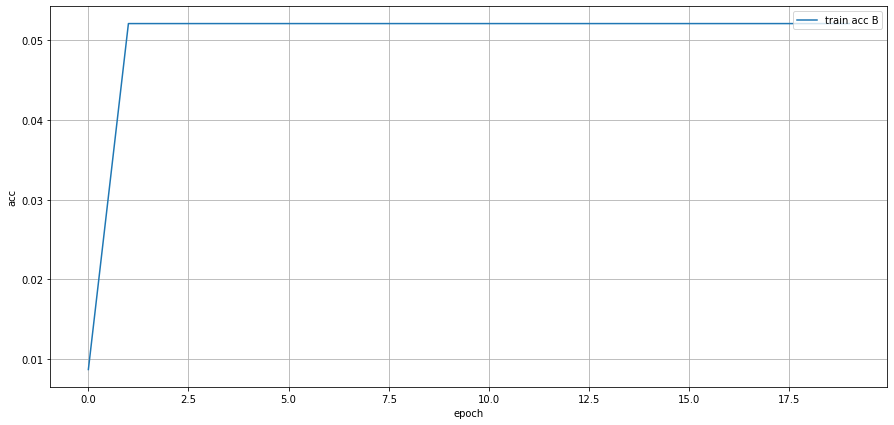

In [18]:
assert n_epochs == len(epoch_train_acc_B), "different epoch length {} {}".format(n_epochs, len(epoch_train_acc_B))
fig, ax = plt.subplots(figsize=(15, 7))
ax.plot(np.arange(n_epochs), epoch_train_acc_B, label="train acc B")
ax.set_xlabel('epoch')
ax.set_ylabel('acc')
ax.grid(True)
plt.legend(loc='upper right')
figname = logDir + model_name_B+"_train1_acc.png"
plt.savefig(figname)
plt.show()

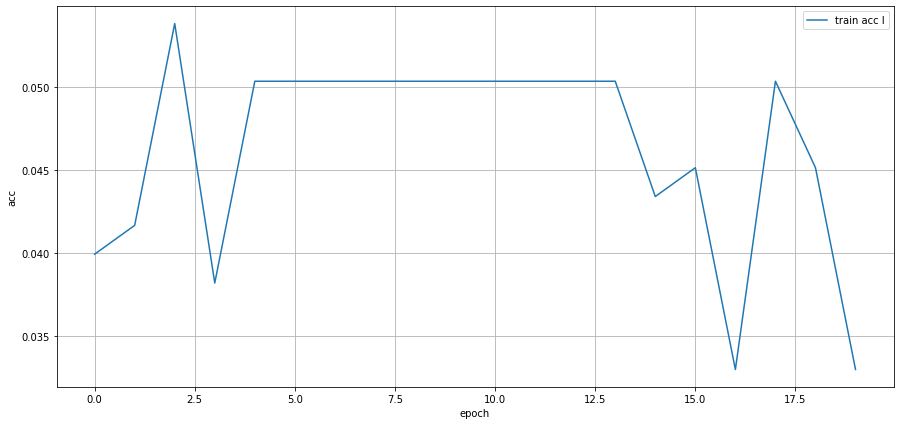

In [19]:
assert n_epochs == len(epoch_train_acc_I), "different epoch length {} {}".format(n_epochs, len(epoch_train_acc_I))
fig, ax = plt.subplots(figsize=(15, 7))
ax.plot(np.arange(n_epochs), epoch_train_acc_I, label="train acc I")
ax.set_xlabel('epoch')
ax.set_ylabel('acc')
ax.grid(True)
plt.legend(loc='upper right')
figname = logDir + model_name_I + "_train1_acc.png"
plt.savefig(figname)
plt.show()


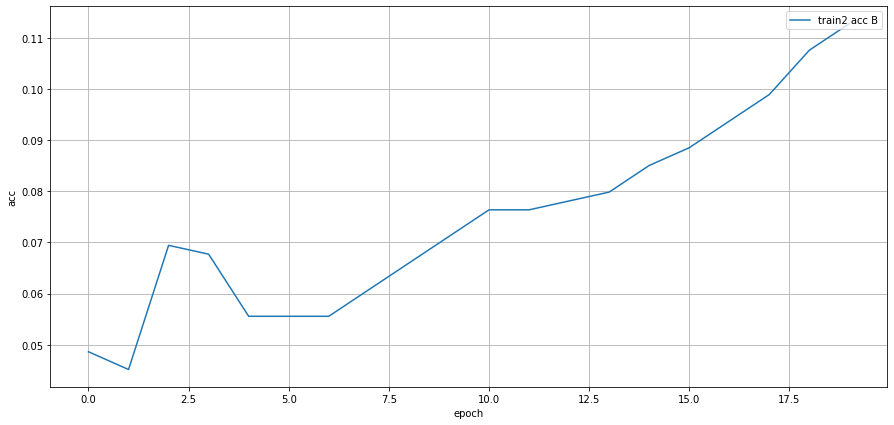

In [20]:
assert n_epochs_2 == len(epoch_cl_train_acc_B), "different epoch length {} {}".format(n_epochs_2, len(epoch_cl_train_acc_B))
fig, ax = plt.subplots(figsize=(15, 7))
ax.plot(np.arange(n_epochs_2), epoch_cl_train_acc_B, label="train2 acc B")
ax.set_xlabel('epoch')
ax.set_ylabel('acc')
ax.grid(True)
plt.legend(loc='upper right')
figname = logDir + model_name_B+"_train2_acc.png"
plt.savefig(figname)
plt.show()

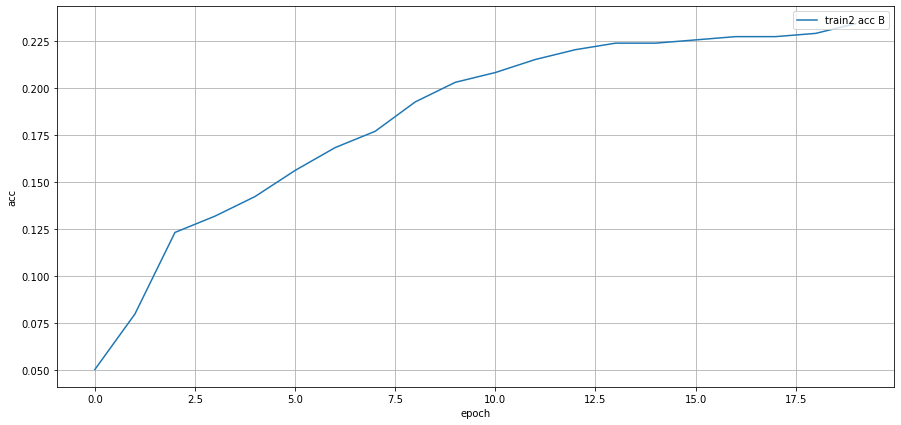

In [21]:
assert n_epochs_2 == len(epoch_cl_train_acc_I), "different epoch length {} {}".format(n_epochs_2, len(epoch_cl_train_acc_I))
fig, ax = plt.subplots(figsize=(15, 7))
ax.plot(np.arange(n_epochs_2), epoch_cl_train_acc_I, label="train2 acc B")
ax.set_xlabel('epoch')
ax.set_ylabel('acc')
ax.grid(True)
plt.legend(loc='upper right')
figname = logDir + model_name_I+"_train2_acc.png"
plt.savefig(figname)
plt.show()